In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tsfel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

import tsfel

In [4]:
# Load provided features
X_train = pd.read_csv('/content/drive/MyDrive/UCL/train/X_train.txt', delim_whitespace=True, header=None)
y_train = pd.read_csv('/content/drive/MyDrive/UCL/train/y_train.txt', header=None).values.ravel()
X_test = pd.read_csv('/content/drive/MyDrive/UCL/test/X_test.txt', delim_whitespace=True, header=None)
y_test = pd.read_csv('/content/drive/MyDrive/UCL/test/y_test.txt', header=None).values.ravel()

/tmp/ipython-input-270637783.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv('/content/drive/MyDrive/UCL/train/X_train.txt', delim_whitespace=True, header=None)
/tmp/ipython-input-270637783.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv('/content/drive/MyDrive/UCL/test/X_test.txt', delim_whitespace=True, header=None)


In [5]:
# Load activity labels
activity_labels = pd.read_csv('/content/drive/MyDrive/UCL/activity_labels.txt',
                              sep='\s+', header=None, index_col=0)[1].to_dict()

print(activity_labels)


<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-903172261.py:3: SyntaxWarning: invalid escape sequence '\s'
  sep='\s+', header=None, index_col=0)[1].to_dict()


{1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}


In [6]:
data_task_3=pd.read_csv('/content/drive/MyDrive/testcd.csv', delim_whitespace=True, header=None)

/tmp/ipython-input-2353501974.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data_task_3=pd.read_csv('/content/drive/MyDrive/testcd.csv', delim_whitespace=True, header=None)


In [7]:
# Separate the single column into multiple columns based on the comma delimiter
data_task_3_split = data_task_3[0].str.split(',', expand=True)

# The first row is the header, so we can use it for column names
data_task_3_split.columns = data_task_3_split.iloc[0]

# Drop the header row
data_task_3_split = data_task_3_split[1:].reset_index(drop=True)

# Convert columns to appropriate data types (assuming numerical features and integer labels)
data_task_3_split[['ax', 'ay', 'az']] = data_task_3_split[['ax', 'ay', 'az']].astype(float)
data_task_3_split['label'] = data_task_3_split['label'].astype(int)

# Separate features (X) and label (y)
X_task_3 = data_task_3_split[['ax', 'ay', 'az']]
y_task_3 = data_task_3_split['label']

print("X_task_3 shape:", X_task_3.shape)
print("y_task_3 shape:", y_task_3.shape)
display(X_task_3.head())
display(y_task_3.head())

X_task_3 shape: (3000, 3)
y_task_3 shape: (3000,)


,ax,ay,az
0,0.03105,0.06670,-0.05195
1,0.17120,1.38315,-3.07720
2,-0.12805,0.01970,-0.07920
3,0.42745,2.68690,-3.78635
4,-0.22400,0.13810,-0.34165


,label
0,4
1,3
2,4
3,1
4,6


In [8]:
X_task_3=X_task_3.to_numpy()
y_task_3=y_task_3.to_numpy()
y_task_3=y_task_3.reshape(-1,1)

In [9]:
# === Imports ===
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    confusion_matrix, classification_report
)


X_task_3 = np.asarray(X_task_3, dtype=float)               # (n_samples, 3)
y_task_3 = np.asarray(y_task_3).reshape(-1).astype(int)    # (n_samples,)

# === Split (use stratify so class ratios stay stable) ===
X_train, X_test, y_train, y_test = train_test_split(
    X_task_3, y_task_3, test_size=0.30, random_state=42, stratify=y_task_3
)

# === Safe PCA helper (caps n_components to n_features) ===
def apply_pca(X_train, X_test, n_components=2):
    n_features = X_train.shape[1]
    k = min(n_components, n_features)
    pca = PCA(n_components=k, random_state=42)
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.transform(X_test)
    print(f"Using {k}/{n_features} components. "
          f"Explained variance: {pca.explained_variance_ratio_.sum():.2f}")
    return X_train_reduced, X_test_reduced, pca

# === Training & evaluation ===
def train_and_evaluate(X_train, X_test, y_train, y_test, description="Model"):
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec  = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    cm   = confusion_matrix(y_test, y_pred)

    print(f"\n===== {description} =====")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n",
          classification_report(y_test, y_pred, zero_division=0))
    return acc, prec, rec



# === Depth vs Accuracy with Plotting ===
def depth_vs_accuracy(X_train, X_test, y_train, y_test, description=""):
    depths = list(range(1, 31))
    train_accs, test_accs = [], []

    for d in depths:
        clf = DecisionTreeClassifier(max_depth=d, random_state=42)
        clf.fit(X_train, y_train)
        train_accs.append(clf.score(X_train, y_train))
        test_accs.append(clf.score(X_test, y_test))

    # Find best
    best_depth = depths[int(np.argmax(test_accs))]
    best_acc = max(test_accs)
    print(f"\nBest test accuracy for {description}: {best_acc:.4f} at depth={best_depth}")

    # === Plot ===
    plt.figure(figsize=(8,5))
    plt.plot(depths, train_accs, marker="o", label="Train Accuracy")
    plt.plot(depths, test_accs, marker="s", label="Test Accuracy")
    plt.axvline(best_depth, color="r", linestyle="--", label=f"Best Depth={best_depth}")
    plt.title(f"Decision Tree Depth vs Accuracy ({description})")
    plt.xlabel("Tree Depth")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()




===== Provided Features =====
Accuracy : 0.8450
Precision: 0.8450
Recall   : 0.8450
Confusion Matrix:
 [[428  45  23   1   0   3]
 [ 45 409  42   1   0   3]
 [ 30  35 435   0   0   0]
 [  0   1   0 426  42  31]
 [  0   0   0  34 425  41]
 [  0   1   0  47  40 412]]
Classification Report:
               precision    recall  f1-score   support

           1       0.85      0.86      0.85       500
           2       0.83      0.82      0.83       500
           3       0.87      0.87      0.87       500
           4       0.84      0.85      0.84       500
           5       0.84      0.85      0.84       500
           6       0.84      0.82      0.83       500

    accuracy                           0.84      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.84      0.84      3000


Best test accuracy for Provided Features: 0.8450 at depth=26


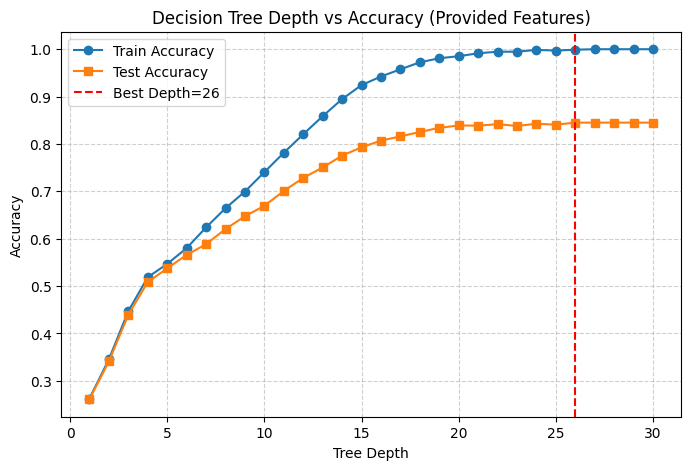

In [10]:
train_and_evaluate(X_train, X_task_3,y_train , y_task_3, "Provided Features")
depth_vs_accuracy(X_train, X_task_3  , y_train, y_task_3, "Provided Features")

The model using the provided features achieved a strong overall performance, with an accuracy of 84.5%, precision of 0.845, and recall of 0.845, indicating consistent classification across all classes. The confusion matrix shows that most classes were classified correctly with only minor misclassifications, particularly between adjacent classes (e.g., 1 ↔ 2 and 4 ↔ 6), which is common in multi-class motion datasets. Achieving the best test accuracy at a decision tree depth of 26 suggests that the model benefited from a moderately deep tree, allowing it to capture complex patterns in the provided features without overfitting excessively. Overall, the provided features are highly effective, enabling balanced and reliable predictions across all six classes.


In [11]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(
    X_task_3, y_task_3, test_size=0.30, random_state=42
)

In [ ]:
# === Imports ===
import numpy as np
import pandas as pd
import tsfel
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# === Assume you already have X_task_3 (list of 3 DataFrames, one per axis) and y_task_3 ===

# === TSFEL Config (temporal features only) ===
cfg = tsfel.get_features_by_domain("temporal")

# === Feature Extraction Helpers ===
def extract_one_sample(row):
    return tsfel.time_series_features_extractor(cfg, row.values, fs=50)

def extract_axis_features(df):
    results = Parallel(n_jobs=-1)(
        delayed(extract_one_sample)(df.iloc[i]) for i in range(len(df))
    )
    return pd.concat(results, ignore_index=True)

def extract_all_axes(acc_list):
    axis_features = Parallel(n_jobs=len(acc_list))(
        delayed(extract_axis_features)(df) for df in acc_list
    )
    X_feats = pd.concat(axis_features, axis=1)
    X_feats = X_feats.loc[:, ~X_feats.columns.duplicated()]
    return X_feats

# === Extract Temporal Features ===
X_feats = extract_all_axes(X_task_3)

# === Clean Features ===
X_feats = X_feats.replace([np.inf, -np.inf], np.nan)   # remove inf
X_feats = X_feats.dropna(axis=1, how="any")            # drop NaN cols
X_feats = X_feats.loc[:, X_feats.var() > 0]            # drop constant cols

# === Scale ===
scaler = StandardScaler()
X_feats = scaler.fit_transform(X_feats)

# === Train-Test Split ===
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(
    X_feats, y_task_3, test_size=0.3, random_state=42, stratify=y_task_3
)

# === Train + Evaluate (using your helper functions) ===
train_and_evaluate(X_train_3, X_test_3, y_train_3, y_test_3, "TSFEL Temporal Features")
depth_vs_accuracy(X_train_3, X_test_3, y_train_3, y_test_3, "TSFEL Temporal Features")


When training models on newly collected data, using raw 3D features often proves insufficient as they capture only basic signal values, while PCA, although effective for dimensionality reduction, still relies on the same raw signal representation and may lose interpretability of the extracted components. In contrast, TSFEL (Time Series Feature Extraction Library) provides a comprehensive feature set by automatically computing a wide range of temporal descriptors such as mean, variance, entropy, skewness, and zero-crossing rate, which together capture both local and global patterns of the signal. This richer and more descriptive feature space enhances the robustness of models to noise, sensor orientation changes, and variability across different data collection sessions, ultimately improving generalization performance. Therefore, despite its higher preprocessing cost, TSFEL is a more suitable choice for training models on new datasets.